## Data report for efficacy dataset from the siRNAmod database

In [1]:
from oligogym.data import DatasetDownloader
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from oligogym.features import KMersCounts
from oligogym.models import RandomForestModel
from oligogym.metrics import regression_metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Processed data

In [2]:
downloader = DatasetDownloader()
dataset = downloader.download("siRNAmod")
dataset.data.head()

,x,y,y_raw,targets,smiles,fasta
0,RNA1{r(G)p.[hna](A)p.r(C)p.r(G)p.r(U)p.r(A)p.r...,84.90,84.90,undefined,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O...,GACGUAAACGGCCACAAGUUC.ACUUGUGGCCGUUUACGUCGC
1,RNA1{r(G)p.r(A)p.r(C)p.r(G)p.r(U)p.r(A)p.r(A)p...,88.70,88.70,undefined,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3C[C@H](n...,GACGUAAACGGCCACAAGUUC.ACUUGUGGCCGUUUACGUCGC
2,RNA1{[fl2r](G)p.m(A)p.[fl2r](C)p.m(G)p.[fl2r](...,87.30,87.30,undefined,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(...,GACGUAAACGGCCACAAGUUC.ACUUGUGGCCGUUUACGUCGC
3,RNA1{r(G)p.r(A)p.r(C)p.r(G)p.r(U)p.r(A)p.r(A)p...,87.40,87.40,undefined,Cc1cn([C@@H]2O[C@@]3(COP(=O)(O)O[C@H]4[C@@H](O...,GACGUAAACGGCCACAAGUTC.ACUUGUGGCCGUUUACGUCGC
4,RNA1{[lna](G)p.r(C)p.r(A)p.r(G)p.r(C)p.r(A)p.r...,73.23,73.23,undefined,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](OP(=O)(O)OC[C@H...,GCAGCACGACUUCUUCAAGUU.CUUGAAGAAGUCGUGCUGCUU


In [3]:
print(dataset.get_helm_stats().to_dict())

{'avg_nt_seq_len': {0: 21.0}, 'combined_unique_monomers': {0: ['A', 'C', 'G', 'T', 'U', 'd', 'fl2r', 'hna', 'lna', 'm', 'p', 'r', 's4r', 'una']}, 'avg_GC_content': {0: 45.48747834304614}, 'avg_G_content': {0: 22.806741219089613}, 'avg_C_content': {0: 34.08410773350133}, 'avg_A_content': {0: 22.790990707197977}, 'avg_TU_content': {0: 31.721530949755856}, 'num_duplicates': {0: 84}}


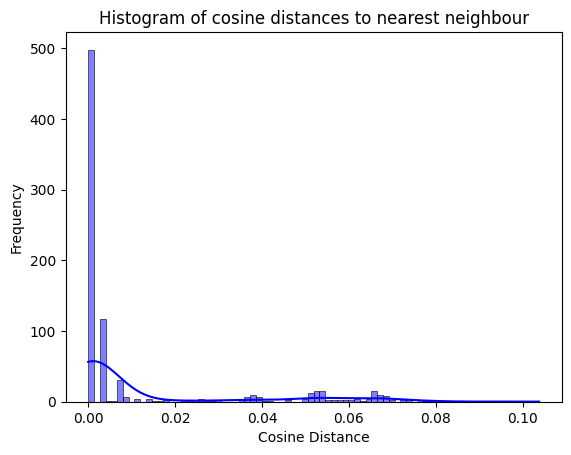

In [4]:
cosine_distances = get_cosine_dist_to_nearest_neighbor(np.unique(dataset.x), kmer_max=6, strands=["RNA1"], modification_abundance=True)

fig, ax = plt.subplots()

sns.histplot(cosine_distances, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

plt.show()

In [5]:
number_similar_sequences = np.sum(cosine_distances == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

155 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


## Labels statistics

In [6]:
print(dataset.get_label_stats().to_dict())

{'nobs': {0: 907}, 'minmax': {0: (0.0, 98.0)}, 'mean': {0: 61.84467475192943}, 'variance': {0: 600.2908496457525}, 'skewness': {0: -0.7426921693882169}, 'kurtosis': {0: -0.32125377312483305}, 'num_zeros': {0: 20}}


In [7]:
print(f"{len(get_outliers(dataset.y))} datapoints are identified as outliers by IQR method")

0 datapoints are identified as outliers by IQR method


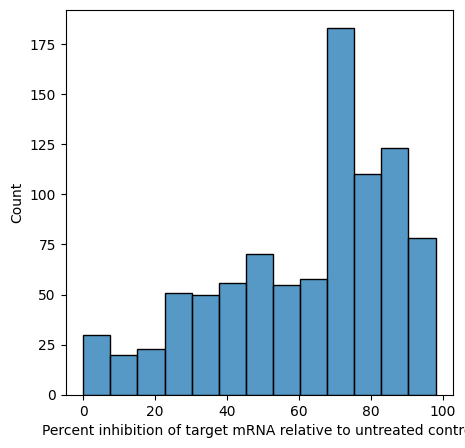

In [8]:
fig,ax=plt.subplots(figsize=[5,5])

sns.histplot(x=dataset.y)
ax.set_xlabel('Percent inhibition of target mRNA relative to untreated control')
plt.show()

## Splitting analysis

In [9]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_random = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

X_train, X_test, y_train, y_test = dataset.split(split_strategy="backbone", random_state=42)
cosine_dist_backbone = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

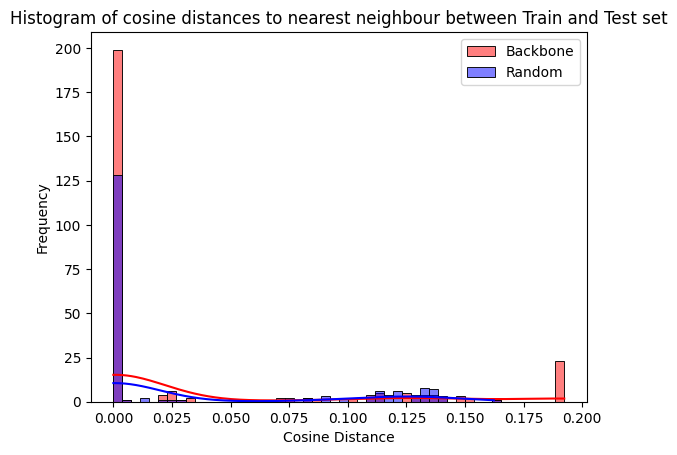

In [10]:
data_min = min(min(cosine_dist_random), min(cosine_dist_backbone))
data_max = max(max(cosine_dist_random), max(cosine_dist_backbone))

num_bins = 50
bin_edges = np.linspace(data_min, data_max, num_bins+1)

fig, ax = plt.subplots()

sns.histplot(cosine_dist_backbone, ax=ax, color='red', kde=True, label='Backbone', bins=bin_edges)
sns.histplot(cosine_dist_random, ax=ax, color='blue', kde=True, label='Random', bins=bin_edges)

ax.set_title('Histogram of cosine distances to nearest neighbour between Train and Test set')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()

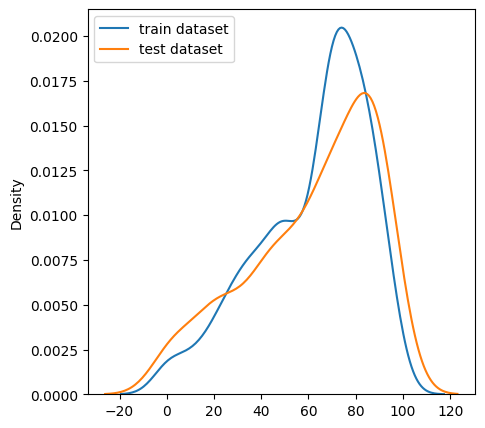

In [11]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="backbone", random_state=42)

fig,ax=plt.subplots(figsize=[5,5])

sns.kdeplot(ax=ax, x=y_train, label='train dataset')
sns.kdeplot(ax=ax, x=y_test, label='test dataset')
ax.legend()
plt.show()

## Predictability analysis

In [12]:
x_train,x_test,y_train,y_test = dataset.split('backbone')
feat=KMersCounts(k = [1,2,3], modification_abundance=True)
x_train=feat.fit_transform(x_train)
x_test=feat.transform(x_test)
model=RandomForestModel()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

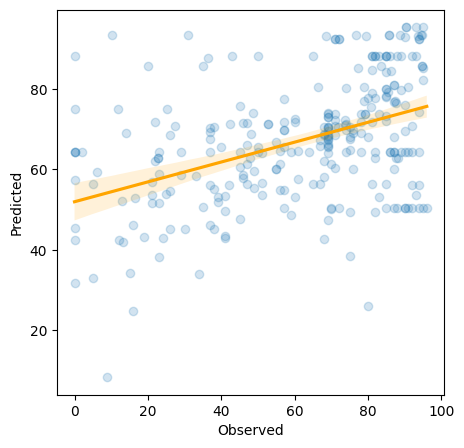

{'r2_score': 0.1235204638649734, 'root_mean_squared_error': 24.891263393372455, 'mean_absolute_error': 18.118259776707394, 'pearson_correlation': 0.43309780927050157, 'spearman_correlation': 0.4118653064034172}


In [13]:
fig, ax = plt.subplots(figsize=[5,5])
sns.regplot(ax=ax,x=y_test,y=y_pred,scatter_kws={'alpha':0.2},line_kws={'color':'orange'})
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()
print(regression_metrics(y_test,y_pred))